In [1]:
%reload_ext autoreload
%autoreload 2

In [1]:
!pip uninstall datasets -y
!pip install torch==2.2 torchvision torchaudio lightning transformers datasets chess numpy pandas scikit-learn

Found existing installation: datasets 2.4.0
Uninstalling datasets-2.4.0:
  Successfully uninstalled datasets-2.4.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 3.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 90.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 82.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 95.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 18.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 12.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 14.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 103.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 34.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━

In [1]:
from datasets import Dataset, DatasetDict, load_dataset, load_from_disk, load_dataset
from lightning_training import *
from data_process.tokenizers import FullMoveTokenizerNoEOS

import pandas as pd
import sqlite3 as db
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from nanoGPT.model import GPT, GPTConfig
from lightning_training import *


In [2]:
dataset = DatasetDict.load_from_disk("../data/split/elo_1900")

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['index', 'id', 'date', 'white_elo', 'black_elo', 'result', 'ply', 'ply_30s', 'piece_uci'],
        num_rows: 6000000
    })
    valid: Dataset({
        features: ['index', 'id', 'date', 'white_elo', 'black_elo', 'result', 'ply', 'ply_30s', 'piece_uci'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['index', 'id', 'date', 'white_elo', 'black_elo', 'result', 'ply', 'ply_30s', 'piece_uci'],
        num_rows: 100000
    })
})

In [4]:
tokenizer = FullMoveTokenizerNoEOS()

model_config = GPTConfig(
    block_size=301,
    vocab_size=len(tokenizer.vocab),
    n_layer=4,
    n_head=4,
    n_embd=256,
    bias=False,
)


In [5]:
data_module = DataModuleMaiaTraining(dataset, num_workers=8, batch_size=64, max_game_length=300)

In [8]:
tensorboard_logger = pl.loggers.TensorBoardLogger(save_dir="./lightning_logs/rating_bins/", name=f"elo_1900")
early_stopping = pl.callbacks.EarlyStopping(monitor="val_loss", patience=1, mode="min")

trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=10,
    callbacks=[pl.callbacks.RichProgressBar(), early_stopping],
    logger=tensorboard_logger,
    precision="bf16-mixed",
    # default_root_dir=
    # fast_dev_run=True
)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [9]:
checkpoint_elo_1100 = "./lightning_logs/rating_bins/elo_1100/version_2/checkpoints/epoch=8-step=843750.ckpt"
checkpoint_elo_1300 = "./lightning_logs/rating_bins/elo_1300/version_1/checkpoints/epoch=7-step=750000.ckpt"
checkpoint_elo_1200 = "./lightning_logs/rating_bins/elo_1200/version_1/checkpoints/epoch=5-step=562500.ckpt"
checkpoint_elo_1400 = "./lightning_logs/rating_bins/elo_1400/version_0/checkpoints/epoch=4-step=468750.ckpt"
checkpoint_elo_1500 = "./lightning_logs/rating_bins/elo_1500/version_0/checkpoints/epoch=1-step=187500.ckpt"
checkpoint_elo_1600 = "./lightning_logs/rating_bins/elo_1600/version_4/checkpoints/epoch=2-step=281250.ckpt"
checkpoint_elo_1700 = "./lightning_logs/rating_bins/elo_1700/version_0/checkpoints/epoch=4-step=468750.ckpt"
checkpoint_elo_1900 = "./lightning_logs/rating_bins/elo_1900/version_1/checkpoints/epoch=8-step=843750.ckpt"



In [10]:
# pl_model = LightningGPT(model_config)
pl_model = LightningGPT.load_from_checkpoint(checkpoint_elo_1900, config=model_config)

number of parameters: 4.19M


In [11]:
torch.set_float32_matmul_precision("high")

In [12]:
trainer.fit(
    model=pl_model,
    datamodule=data_module,
    ckpt_path=checkpoint_elo_1900
)

Epoch 9/9  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93750/93750 0:28:19 • 0:00:00 54.15it/s v_num: 2.000 train_loss: 1.822
Validation ━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━ 1112/1563   0:00:12 • 0:00:06 88.73it/s

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [14]:
trainer.validate(model=pl_model, datamodule=data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

In [32]:
trainer.test(
    model=pl_model,
    datamodule=data_module,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.44945967197418213    │
│         test_loss         │    1.7625641822814941     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.7625641822814941, 'test_acc': 0.44945967197418213}]

In [ ]:
pl_model_1200 = LightningGPT.load_from_checkpoint(checkpoint_elo_1200, config=model_config)
trainer.test(
    model=pl_model_1200,
    datamodule=data_module,
)

In [39]:
results = {}

trainer = pl.Trainer(
    accelerator="gpu",
    # default_root_dir=
    # fast_dev_run=True
)

for elo in range(1100, 2000, 100):
    print(f"Testing model for elo {elo}")
    dataset_dict = DatasetDict.load_from_disk(f"./data/huggingface_datasets/elo_bins/split/elo_{elo}")

    data_module = DataModuleMaiaTraining(dataset_dict, num_workers=13, batch_size=64, max_game_length=300)

    result = trainer.test(
        model=pl_model,
        datamodule=data_module,
    )

    results[elo] = result

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Testing model for elo 1100


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.44438374042510986    │
│         test_loss         │    1.7930240631103516     │
└───────────────────────────┴───────────────────────────┘

Testing model for elo 1200


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.44801145792007446    │
│         test_loss         │    1.7726563215255737     │
└───────────────────────────┴───────────────────────────┘

Testing model for elo 1300


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.44945967197418213    │
│         test_loss         │    1.7625641822814941     │
└───────────────────────────┴───────────────────────────┘

Testing model for elo 1400


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.45020854473114014    │
│         test_loss         │    1.7569758892059326     │
└───────────────────────────┴───────────────────────────┘

Testing model for elo 1500


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4475384056568146     │
│         test_loss         │    1.7647216320037842     │
└───────────────────────────┴───────────────────────────┘

Testing model for elo 1600


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.44617968797683716    │
│         test_loss         │     1.768670916557312     │
└───────────────────────────┴───────────────────────────┘

Testing model for elo 1700


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.44235676527023315    │
│         test_loss         │    1.7823188304901123     │
└───────────────────────────┴───────────────────────────┘

Testing model for elo 1800


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4372258186340332     │
│         test_loss         │    1.8019871711730957     │
└───────────────────────────┴───────────────────────────┘

Testing model for elo 1900


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.43153825402259827    │
│         test_loss         │     1.820486068725586     │
└───────────────────────────┴───────────────────────────┘

In [40]:
results

{1100: [{'test_loss': 1.7930240631103516, 'test_acc': 0.44438374042510986}],
 1200: [{'test_loss': 1.7726563215255737, 'test_acc': 0.44801145792007446}],
 1300: [{'test_loss': 1.7625641822814941, 'test_acc': 0.44945967197418213}],
 1400: [{'test_loss': 1.7569758892059326, 'test_acc': 0.45020854473114014}],
 1500: [{'test_loss': 1.7647216320037842, 'test_acc': 0.4475384056568146}],
 1600: [{'test_loss': 1.768670916557312, 'test_acc': 0.44617968797683716}],
 1700: [{'test_loss': 1.7823188304901123, 'test_acc': 0.44235676527023315}],
 1800: [{'test_loss': 1.8019871711730957, 'test_acc': 0.4372258186340332}],
 1900: [{'test_loss': 1.820486068725586, 'test_acc': 0.43153825402259827}]}

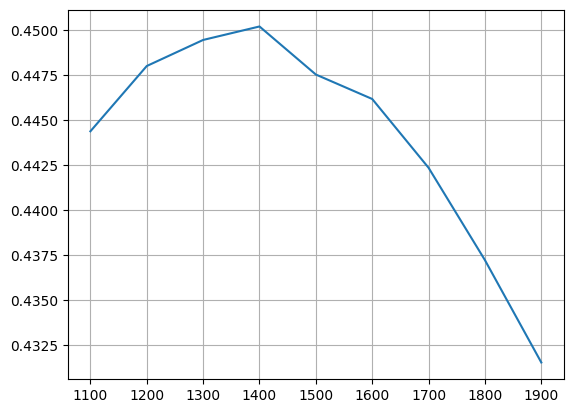

In [56]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline


x = list(results.keys())
y = [result[0]["test_acc"] for result in results.values()]

plt.plot(x, y)
plt.grid()

plt.show()